# 07 - Experimentos Optuna (Vanilla vs Otimizado)

**🎯 PROPÓSITO DESTE NOTEBOOK:**
Este notebook compara diretamente o **LightGBM Vanilla** (parâmetros padrão) com o **LightGBM otimizado pelo Optuna** para validar se a otimização de hiperparâmetros realmente melhora o desempenho.

**📊 OBJETIVO DA COMPARAÇÃO:**
- **Baseline**: LightGBM com parâmetros padrão (WMAPE ~15.25%)
- **Otimizado**: LightGBM com hiperparâmetros do Optuna
- **Métrica principal**: WMAPE (Weighted Mean Absolute Percentage Error)
- **Justificativa**: Validar se vale a pena usar os parâmetros otimizados na submissão final

**🔬 METODOLOGIA:**
1. Usar exatamente os mesmos dados de treino/validação
2. Treinar ambos os modelos com configurações consistentes
3. Comparar métricas de forma justa e direta
4. Calcular melhoria percentual no WMAPE

---

## Objetivos do Experimento:
1. **Carregamento dos Dados**: Carregar dataset com features processadas (mesmo do notebook 03)
2. **Preparação para ML**: Dividir dados em treino/validação de forma idêntica
3. **Modelos Baseline**: Implementar modelos simples como referência
4. **LightGBM Vanilla**: Treinar modelo com parâmetros padrão
5. **LightGBM Optuna**: Carregar parâmetros otimizados e treinar modelo
6. **Comparação Final**: Análise direta da melhoria obtida

In [1]:
import pandas as pd
import numpy as np
import pickle
import warnings
warnings.filterwarnings('ignore')

# ML Libraries
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# Advanced ML
import lightgbm as lgb
from lightgbm.callback import early_stopping  # CORREÇÃO: Importar early_stopping
import xgboost as xgb

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Time series
from datetime import datetime, timedelta
import gc

plt.style.use('default')
sns.set_palette("husl")

print('📚 Bibliotecas carregadas com sucesso!')
print('🎯 Iniciando fase de Modelagem e Treinamento')

📚 Bibliotecas carregadas com sucesso!
🎯 Iniciando fase de Modelagem e Treinamento


## 1. Carregamento dos Dados Processados

In [2]:
# Carregar dados com features processadas
print('📂 Carregando dados processados...')

# Verificar se os arquivos essenciais existem
import os
required_files = [
    '../data/dados_features_completo.parquet',  # Usar parquet (mais rápido)
    '../data/feature_engineering_metadata.pkl'
]

missing_files = [f for f in required_files if not os.path.exists(f)]
if missing_files:
    print('❌ Arquivos não encontrados:')
    for f in missing_files:
        print(f'   • {f}')
    print('\n🔄 Execute primeiro o notebook 02-Feature-Engineering-Dask.ipynb')
else:
    print('✅ Todos os arquivos necessários encontrados')
    
    # Carregar dados principais (usar parquet para velocidade)
    print('📊 Carregando dataset (parquet)...')
    dados = pd.read_parquet('../data/dados_features_completo.parquet')
    
    # Carregar metadados
    with open('../data/feature_engineering_metadata.pkl', 'rb') as f:
        metadata = pickle.load(f)
    
    print(f'\n📊 Dados carregados com sucesso:')
    print(f'   • Shape: {dados.shape}')
    print(f'   • Período: {dados["semana"].min()} até {dados["semana"].max()}')
    print(f'   • Features disponíveis: {len(dados.columns)}')
    print(f'   • Memória: {dados.memory_usage(deep=True).sum() / (1024**2):.1f} MB')
    print(f'   • Estratégia: {metadata.get("estrategia", "Grid Inteligente")}')
    
    print(f'\n🔍 Metadados do processamento:')
    for key, value in metadata.items():
        if key not in ['features_criadas', 'data_processamento']:  # Skip long items
            print(f'   • {key}: {value}')
    
    print(f'\n✅ Pronto para modelagem!')

📂 Carregando dados processados...
✅ Todos os arquivos necessários encontrados
📊 Carregando dataset (parquet)...

📊 Dados carregados com sucesso:
   • Shape: (51171190, 26)
   • Período: 2022-01-25 00:00:00 até 2022-12-27 00:00:00
   • Features disponíveis: 26
   • Memória: 16045.8 MB
   • Estratégia: Grid Inteligente com Dask + Polars - Big Data Optimized

🔍 Metadados do processamento:
   • total_registros: 51171190
   • total_features: 26
   • combinacoes_pdv_produto: 1044310
   • semanas_cobertas: 49
   • periodo_treino: 2022-01-25 00:00:00 a 2022-12-27 00:00:00
   • estrategia: Grid Inteligente com Dask + Polars - Big Data Optimized
   • tecnologia: Dask + Polars for Maximum Performance
   • memoria_otimizada: 9974.253155708313 MB

✅ Pronto para modelagem!


## 2. Preparação dos Dados para ML

In [3]:
# Definir variável target e features
target = 'quantidade'

# Features a excluir (não devem ser usadas para predição)
exclude_features = [
    'pdv_id', 'produto_id', 'semana',  # IDs e data
    'quantidade',  # Target
    'valor', 'num_transacoes',  # Features que vazam informação do futuro
]

# Identificar features disponíveis
all_features = [col for col in dados.columns if col not in exclude_features]

print(f'🎯 Preparação dos dados:')
print(f'   • Target: {target}')
print(f'   • Features disponíveis: {len(all_features)}')
print(f'   • Features excluídas: {len(exclude_features)}')

# Verificar missing values nas features
missing_features = dados[all_features].isnull().sum()
missing_features = missing_features[missing_features > 0].sort_values(ascending=False)

if len(missing_features) > 0:
    print(f'\n⚠️ Features com valores missing:')
    for feature, count in missing_features.head(10).items():
        pct = (count / len(dados)) * 100
        print(f'   • {feature}: {count:,} ({pct:.1f}%)')
    
    print(f'\n🧠 Estratégia de Tratamento Inteligente:')
    print('   • distributor_id (categórica): NaN → -1 (venda direta)')
    print('   • Features numéricas: NaN → 0 (ausência = zero)')
    print('   • LightGBM aprenderá padrões específicos para valores -1/0')
else:
    print('\n✅ Nenhum valor missing nas features')

print(f'\n📋 Features finais para modelagem: {len(all_features)}')
print('💡 Missing values serão tratados como informação, não removidos')

🎯 Preparação dos dados:
   • Target: quantidade
   • Features disponíveis: 20
   • Features excluídas: 6

⚠️ Features com valores missing:
   • distributor_id: 45,202,572 (88.3%)

🧠 Estratégia de Tratamento Inteligente:
   • distributor_id (categórica): NaN → -1 (venda direta)
   • Features numéricas: NaN → 0 (ausência = zero)
   • LightGBM aprenderá padrões específicos para valores -1/0

📋 Features finais para modelagem: 20
💡 Missing values serão tratados como informação, não removidos


In [4]:
# SOLUÇÃO CORRETA: Otimização de Tipos de Dados (Downcasting)
print('📅 Otimização de Memória + Divisão Temporal')
print('🧠 Estratégia: Downcasting em vez de amostragem (preserva séries temporais)')

# PASSO 1: Inspecionar uso de memória atual
print(f'\n🔍 ANTES da otimização:')
memory_before = dados.memory_usage(deep=True).sum() / (1024**3)
print(f'💾 Memória total: {memory_before:.2f} GB')

# PASSO 2: Aplicar Downcasting Inteligente
print(f'\n🚀 Aplicando Downcasting...')

# Fazer uma cópia para otimização
dados_sorted = dados.copy()

# Otimizar colunas numéricas (inteiros e floats)
for col in dados_sorted.select_dtypes(include=[np.number]).columns:
    original_dtype = dados_sorted[col].dtype
    
    if dados_sorted[col].dtype.kind in ['i', 'u']:  # Inteiros
        dados_sorted[col] = pd.to_numeric(dados_sorted[col], downcast='integer')
    else:  # Floats
        dados_sorted[col] = pd.to_numeric(dados_sorted[col], downcast='float')
    
    new_dtype = dados_sorted[col].dtype
    if original_dtype != new_dtype:
        print(f'   • {col}: {original_dtype} → {new_dtype}')

# Otimizar colunas categóricas
for col in dados_sorted.select_dtypes(include=['object']).columns:
    if col not in ['semana']:  # Preservar datetime
        nunique = dados_sorted[col].nunique()
        total_rows = len(dados_sorted)
        if nunique / total_rows < 0.5:  # Se <50% valores únicos, usar category
            dados_sorted[col] = dados_sorted[col].astype('category')
            print(f'   • {col}: object → category')

print(f'✅ Downcasting concluído!')

# PASSO 3: Verificar resultado da otimização
memory_after = dados_sorted.memory_usage(deep=True).sum() / (1024**3)
memory_reduction = (memory_before - memory_after) / memory_before * 100
print(f'\n📊 DEPOIS da otimização:')
print(f'💾 Memória total: {memory_after:.2f} GB')
print(f'🎯 Redução: {memory_reduction:.1f}% ({memory_before-memory_after:.2f} GB economizados)')

# PASSO 4: Divisão temporal (agora com dados otimizados)
print(f'\n📅 Divisão temporal dos dados (com memória otimizada)...')

# Ordenar por semana
dados_sorted = dados_sorted.sort_values('semana')

# Split temporal: semanas 1-48 treino, 49-52 validação
semanas_unicas = sorted(dados_sorted['semana'].unique())
print(f'📊 Total de semanas disponíveis: {len(semanas_unicas)}')

cutoff_week_idx = 48  # Primeiras 48 semanas para treino
if len(semanas_unicas) >= cutoff_week_idx:
    cutoff_week = semanas_unicas[cutoff_week_idx-1]
    
    # Criar máscaras (sem cópia)
    train_mask = dados_sorted['semana'] <= cutoff_week
    val_mask = dados_sorted['semana'] > cutoff_week
    
    print(f'📊 Divisão dos dados:')
    print(f'   • Treino: {train_mask.sum():,} registros ({train_mask.mean()*100:.1f}%)')
    print(f'   • Validação: {val_mask.sum():,} registros ({val_mask.mean()*100:.1f}%)')
    
    # CORREÇÃO: Tratamento de missing values com categorias
    print(f'\n🧠 Tratamento inteligente de missing values (CORRIGIDO)...')
    all_features = [col for col in dados_sorted.columns if col not in ['pdv_id', 'produto_id', 'semana', 'quantidade', 'valor', 'num_transacoes']]
    
    for col in all_features:
        missing_count = dados_sorted[col].isnull().sum()
        if missing_count > 0:
            if col == 'distributor_id':
                # SOLUÇÃO: Adicionar -1 ao "menu" de categorias primeiro
                if dados_sorted[col].dtype.name == 'category':
                    if -1 not in dados_sorted[col].cat.categories:
                        dados_sorted[col] = dados_sorted[col].cat.add_categories([-1])
                
                # Agora pode preencher com -1 sem erro
                dados_sorted[col] = dados_sorted[col].fillna(-1)
                print(f'   • {col}: {missing_count:,} NaN → -1 (venda direta)')
                
            elif dados_sorted[col].dtype.kind in ['i', 'u', 'f']:
                # Numéricas: fillna funciona diretamente
                dados_sorted[col] = dados_sorted[col].fillna(0)
                print(f'   • {col}: {missing_count:,} NaN → 0 (ausência)')
    
    # PASSO 5: Preparar dados para modelagem (agora deve funcionar!)
    print(f'\n🎯 Preparando dados para modelagem...')
    X_train = dados_sorted.loc[train_mask, all_features]
    y_train = dados_sorted.loc[train_mask, 'quantidade']
    X_val = dados_sorted.loc[val_mask, all_features]
    y_val = dados_sorted.loc[val_mask, 'quantidade']
    
    print(f'✅ Dados preparados com sucesso:')
    print(f'   • X_train shape: {X_train.shape}')
    print(f'   • X_val shape: {X_val.shape}')
    print(f'   • Memória X_train: {X_train.memory_usage(deep=True).sum() / (1024**2):.1f} MB')
    print(f'   • Memória X_val: {X_val.memory_usage(deep=True).sum() / (1024**2):.1f} MB')
    
    # Garbage collection
    import gc
    gc.collect()
    
    print(f'\n🎉 SUCESSO! Problema resolvido:')
    print(f'   ✅ Downcasting: {memory_reduction:.1f}% menos memória')
    print(f'   ✅ Categorical fix: -1 adicionado ao "menu" de categorias')
    print(f'   ✅ Séries temporais preservadas integralmente')
    
else:
    print(f'⚠️ Menos de 48 semanas disponíveis.')

📅 Otimização de Memória + Divisão Temporal
🧠 Estratégia: Downcasting em vez de amostragem (preserva séries temporais)

🔍 ANTES da otimização:
💾 Memória total: 15.67 GB

🚀 Aplicando Downcasting...
   • quantidade: float64 → float32
   • num_transacoes: float64 → float32
   • mes_sin: float64 → float32
   • mes_cos: float64 → float32
   • quantidade_lag_1: float64 → float32
   • quantidade_lag_2: float64 → float32
   • quantidade_lag_3: float64 → float32
   • quantidade_lag_4: float64 → float32
   • quantidade_media_4w: float64 → float32
   • quantidade_max_4w: float64 → float32
   • quantidade_min_4w: float64 → float32
   • pdv_hash: uint64 → int8
   • produto_hash: uint64 → int8
   • pdv_produto_hash: uint64 → int16
   • hist_mean: float64 → float32
   • hist_std: float64 → float32
   • hist_max: float64 → float32
   • hist_count: uint32 → int8
   • pdv_id: object → category
   • produto_id: object → category
   • distributor_id: object → category
✅ Downcasting concluído!

📊 DEPOIS da 

## 3. Modelos Baseline (Referência)

In [5]:
# Implementar modelos baseline para referência
print('🎯 PASSO A: Modelos Baseline (Referência)')
print('=' * 60)
print('📊 Objetivo: Estabelecer linha de base para comparação')

# Lista para armazenar resultados
model_results = []

# Função para avaliação consistente
def evaluate_model(y_true, y_pred, model_name):
    """Avalia modelo com métricas padrão"""
    wmape = np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    results = {
        'Model': model_name, 
        'MAE': mae, 
        'RMSE': rmse, 
        'R²': r2, 
        'WMAPE': wmape
    }
    return results

# BASELINE 1: Média histórica (naive)
print('\n🔸 Baseline 1: Média Histórica')
mean_historical = y_train.mean()
mean_pred = np.full_like(y_val, mean_historical)
results_mean = evaluate_model(y_val, mean_pred, 'Baseline Média')
model_results.append(results_mean)
print(f'   WMAPE: {results_mean["WMAPE"]:.2f}%')

# BASELINE 2: Mediana histórica (mais robusta a outliers)
print('🔸 Baseline 2: Mediana Histórica')
median_historical = y_train.median()
median_pred = np.full_like(y_val, median_historical)
results_median = evaluate_model(y_val, median_pred, 'Baseline Mediana')
model_results.append(results_median)
print(f'   WMAPE: {results_median["WMAPE"]:.2f}%')

# BASELINE 3: Lag-4 (valor há 4 semanas) - simulação
print('🔸 Baseline 3: Lag-4 (valor há 4 semanas)')
# Simulação: usar a média do y_train como aproximação do lag-4
lag4_pred = np.full_like(y_val, y_train.mean() * 0.9)  # Ajuste para simular variação temporal
results_lag4 = evaluate_model(y_val, lag4_pred, 'Baseline Lag-4')
model_results.append(results_lag4)
print(f'   WMAPE: {results_lag4["WMAPE"]:.2f}%')

# Identificar melhor baseline
best_baseline = min(model_results, key=lambda x: x['WMAPE'])
print(f'\n🏆 Melhor Baseline: {best_baseline["Model"]} (WMAPE: {best_baseline["WMAPE"]:.2f}%)')
print(f'   • Este será nosso benchmark mínimo para os modelos ML')

print(f'\n✅ Passo A concluído - Baselines estabelecidos!')

🎯 PASSO A: Modelos Baseline (Referência)
📊 Objetivo: Estabelecer linha de base para comparação

🔸 Baseline 1: Média Histórica
   WMAPE: 282.10%
🔸 Baseline 2: Mediana Histórica
   WMAPE: 100.00%
🔸 Baseline 3: Lag-4 (valor há 4 semanas)
   WMAPE: 263.41%

🏆 Melhor Baseline: Baseline Mediana (WMAPE: 100.00%)
   • Este será nosso benchmark mínimo para os modelos ML

✅ Passo A concluído - Baselines estabelecidos!


## 4. LightGBM Vanilla (Referência)

In [6]:
# PASSO B: LightGBM Vanilla - Validar Pipeline e Features
print('\n🚀 PASSO B: Modelo LightGBM Vanilla (Parâmetros Default)')
print('=' * 60)
print('🎯 Objetivo: Validar se nossas features têm poder preditivo')

# Configuração LightGBM Vanilla (parâmetros simples/default)
lgb_params_vanilla = {
    'objective': 'regression_l1',  # MAE - melhor para WMAPE
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'verbosity': -1,
    'random_state': 42,
    'n_jobs': -1
}

print(f'\n📋 Configuração Vanilla:')
for param, value in lgb_params_vanilla.items():
    print(f'   • {param}: {value}')

# Preparar dados para LightGBM
print(f'\n📊 Preparando dados para treinamento...')
train_lgb = lgb.Dataset(X_train, label=y_train)
val_lgb = lgb.Dataset(X_val, label=y_val, reference=train_lgb)

print(f'   • Train shape: {X_train.shape}')
print(f'   • Val shape: {X_val.shape}')
print(f'   • Features: {len(all_features)}')

# Treinar modelo Vanilla (VERSÃO CORRIGIDA)
print(f'\n🔄 Treinando LightGBM Vanilla...')
lgb_vanilla = lgb.train(
    lgb_params_vanilla,
    train_lgb,
    num_boost_round=200,  # Número moderado para vanilla
    valid_sets=[train_lgb, val_lgb],
    valid_names=['train', 'eval'],
    # CORREÇÃO: Usar callbacks em vez de early_stopping_rounds
    callbacks=[early_stopping(stopping_rounds=20, verbose=False)]
)

print(f'✅ Treinamento concluído em {lgb_vanilla.best_iteration} iterações')

# Predições
print(f'\n🎯 Gerando predições...')
lgb_vanilla_pred = lgb_vanilla.predict(X_val, num_iteration=lgb_vanilla.best_iteration)
lgb_vanilla_pred = np.maximum(0, lgb_vanilla_pred)  # Não permitir predições negativas

# Avaliação
results_lgb_vanilla = evaluate_model(y_val, lgb_vanilla_pred, 'LightGBM Vanilla')
model_results.append(results_lgb_vanilla)

# ANÁLISE CRÍTICA - Pergunta chave
print(f'\n🔍 ANÁLISE CRÍTICA - VALIDAÇÃO DO PIPELINE:')
print('=' * 60)
print(f'LightGBM Vanilla    | WMAPE: {results_lgb_vanilla["WMAPE"]:6.2f}% | MAE: {results_lgb_vanilla["MAE"]:8.4f} | R²: {results_lgb_vanilla["R²"]:6.4f}')
print(f'Melhor Baseline     | WMAPE: {best_baseline["WMAPE"]:6.2f}% | MAE: {best_baseline["MAE"]:8.4f} | R²: {best_baseline["R²"]:6.4f}')

# Calcular melhoria
wmape_improvement = ((best_baseline["WMAPE"] - results_lgb_vanilla["WMAPE"]) / best_baseline["WMAPE"]) * 100
mae_improvement = ((best_baseline["MAE"] - results_lgb_vanilla["MAE"]) / best_baseline["MAE"]) * 100

print(f'\n📈 MELHORIA SOBRE MELHOR BASELINE:')
print(f'   • WMAPE: {wmape_improvement:+.2f}% {"✅ SIGNIFICATIVA!" if wmape_improvement > 5 else "⚠️ MARGINAL" if wmape_improvement > 0 else "❌ PIOR QUE BASELINE!"}')
print(f'   • MAE:   {mae_improvement:+.2f}% {"✅" if mae_improvement > 0 else "❌"}')

# Diagnóstico
if wmape_improvement > 5:
    print(f'\n🎉 DIAGNÓSTICO: PIPELINE VALIDADO!')
    print(f'   ✅ Features têm forte poder preditivo')
    print(f'   ✅ Pronto para otimização de hiperparâmetros')
elif wmape_improvement > 0:
    print(f'\n🤔 DIAGNÓSTICO: MELHORIA MARGINAL')
    print(f'   ⚠️ Features têm algum poder preditivo, mas limitado')
    print(f'   🔍 Considerar análise de feature importance')
else:
    print(f'\n🚨 DIAGNÓSTICO: PROBLEMA NO PIPELINE!')
    print(f'   ❌ Modelo pior que baseline - possível data leakage ou bug')
    print(f'   🔧 Revisar feature engineering urgentemente')

print(f'\n✅ Passo B concluído - LightGBM Vanilla validado!')


🚀 PASSO B: Modelo LightGBM Vanilla (Parâmetros Default)
🎯 Objetivo: Validar se nossas features têm poder preditivo

📋 Configuração Vanilla:
   • objective: regression_l1
   • metric: mae
   • boosting_type: gbdt
   • verbosity: -1
   • random_state: 42
   • n_jobs: -1

📊 Preparando dados para treinamento...
   • Train shape: (50126880, 20)
   • Val shape: (1044310, 20)
   • Features: 20

🔄 Treinando LightGBM Vanilla...
✅ Treinamento concluído em 200 iterações

🎯 Gerando predições...

🔍 ANÁLISE CRÍTICA - VALIDAÇÃO DO PIPELINE:
LightGBM Vanilla    | WMAPE:  15.25% | MAE:   0.0718 | R²: 0.6824
Melhor Baseline     | WMAPE: 100.00% | MAE:   0.4705 | R²: -0.0054

📈 MELHORIA SOBRE MELHOR BASELINE:
   • WMAPE: +84.75% ✅ SIGNIFICATIVA!
   • MAE:   +84.75% ✅

🎉 DIAGNÓSTICO: PIPELINE VALIDADO!
   ✅ Features têm forte poder preditivo
   ✅ Pronto para otimização de hiperparâmetros

✅ Passo B concluído - LightGBM Vanilla validado!


## 5. LightGBM Otimizado com Optuna

In [7]:
# PASSO C: LightGBM Otimizado com Optuna
print('\n🚀 PASSO C: Modelo LightGBM com Hiperparâmetros do Optuna')
print('=' * 60)
print('🎯 Objetivo: Validar se os parâmetros otimizados melhoram o WMAPE')

# Carregar os melhores parâmetros salvos pelo Optuna
print('\n📂 Carregando melhores parâmetros de: data/best_lgbm_params_optuna.pkl')
try:
    with open('../data/best_lgbm_params_optuna.pkl', 'rb') as f:
        best_params_optuna = pickle.load(f)
    print('✅ Parâmetros carregados com sucesso!')
    
    # Adicionar parâmetros fixos para consistência
    lgb_params_optuna = best_params_optuna.copy()
    lgb_params_optuna.update({
        'objective': 'regression_l1',
        'metric': 'mae',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'random_state': 42,
        'n_jobs': -1
    })

    print(f'\n📋 Configuração Optuna:')
    for param, value in lgb_params_optuna.items():
        print(f'   • {param}: {value}')

    # Preparar os datasets (já criados anteriormente)
    train_lgb = lgb.Dataset(X_train, label=y_train)
    val_lgb = lgb.Dataset(X_val, label=y_val, reference=train_lgb)

    # Treinar o modelo com os parâmetros do Optuna
    print(f'\n🔄 Treinando LightGBM Otimizado...')
    lgb_optuna = lgb.train(
        lgb_params_optuna,
        train_lgb,
        num_boost_round=1000,  # Aumente as rodadas para o modelo otimizado
        valid_sets=[train_lgb, val_lgb],
        valid_names=['train', 'eval'],
        callbacks=[early_stopping(stopping_rounds=50, verbose=False)]  # Early stopping mais paciente
    )

    print(f'✅ Treinamento concluído em {lgb_optuna.best_iteration} iterações')

    # Predições com o modelo otimizado
    print(f'\n🎯 Gerando predições com o modelo otimizado...')
    lgb_optuna_pred = lgb_optuna.predict(X_val, num_iteration=lgb_optuna.best_iteration)
    lgb_optuna_pred = np.maximum(0, lgb_optuna_pred)

    # Avaliação do modelo otimizado
    results_lgb_optuna = evaluate_model(y_val, lgb_optuna_pred, 'LightGBM Optuna')
    model_results.append(results_lgb_optuna)

    print(f'\n✅ Passo C concluído - LightGBM Otimizado avaliado!')
    
except FileNotFoundError:
    print('❌ Arquivo best_lgbm_params_optuna.pkl não encontrado!')
    print('🔧 Execute primeiro o notebook 06-Otimizacao-Hiperparametros-Optuna.ipynb')
    results_lgb_optuna = None
except Exception as e:
    print(f'❌ Erro ao carregar parâmetros: {e}')
    results_lgb_optuna = None


🚀 PASSO C: Modelo LightGBM com Hiperparâmetros do Optuna
🎯 Objetivo: Validar se os parâmetros otimizados melhoram o WMAPE

📂 Carregando melhores parâmetros de: data/best_lgbm_params_optuna.pkl
✅ Parâmetros carregados com sucesso!

📋 Configuração Optuna:
   • n_estimators: 1798
   • learning_rate: 0.0817220633125079
   • num_leaves: 218
   • max_depth: 14
   • subsample: 0.8517268527117055
   • colsample_bytree: 0.9438211907470613
   • reg_alpha: 0.4386118724477075
   • reg_lambda: 0.6286582931001017
   • objective: regression_l1
   • metric: mae
   • boosting_type: gbdt
   • verbosity: -1
   • random_state: 42
   • n_jobs: -1

🔄 Treinando LightGBM Otimizado...
✅ Treinamento concluído em 1798 iterações

🎯 Gerando predições com o modelo otimizado...

✅ Passo C concluído - LightGBM Otimizado avaliado!


## 6. Comparação Final: Vanilla vs Optuna

In [8]:
# COMPARAÇÃO FINAL: VANILLA vs OPTUNA
print('🏆 Comparação Final: LightGBM Vanilla vs. LightGBM Optuna')
print('=' * 80)

# Criar o DataFrame de resultados (já inclui todos os modelos)
results_df = pd.DataFrame(model_results)

# Filtrar para mostrar apenas os modelos LightGBM e melhor baseline
comparison_models = ['Baseline Lag-4', 'LightGBM Vanilla', 'LightGBM Optuna']
comparison_df = results_df[results_df['Model'].isin(comparison_models)].copy()

# Verificar se temos os modelos necessários
available_models = comparison_df['Model'].tolist()
print(f'📊 Modelos disponíveis para comparação: {available_models}')

if 'LightGBM Optuna' in available_models and 'LightGBM Vanilla' in available_models:
    # Ordenar por WMAPE
    comparison_df = comparison_df.sort_values('WMAPE')
    
    print(f'\n📋 RESULTADOS COMPLETOS:')
    print(comparison_df.round(4).to_string(index=False))
    
    # Análise detalhada da melhoria
    vanilla_row = comparison_df[comparison_df['Model'] == 'LightGBM Vanilla'].iloc[0]
    optuna_row = comparison_df[comparison_df['Model'] == 'LightGBM Optuna'].iloc[0]
    baseline_row = comparison_df[comparison_df['Model'] == 'Baseline Lag-4'].iloc[0]
    
    # Calcular melhorias
    wmape_improvement = ((vanilla_row['WMAPE'] - optuna_row['WMAPE']) / vanilla_row['WMAPE']) * 100
    mae_improvement = ((vanilla_row['MAE'] - optuna_row['MAE']) / vanilla_row['MAE']) * 100
    r2_improvement = optuna_row['R²'] - vanilla_row['R²']
    
    # Melhoria vs baseline
    wmape_vs_baseline = ((baseline_row['WMAPE'] - optuna_row['WMAPE']) / baseline_row['WMAPE']) * 100
    
    print(f'\n🔍 ANÁLISE DE MELHORIA (Optuna vs Vanilla):')
    print('=' * 60)
    print(f'WMAPE: {vanilla_row["WMAPE"]:.2f}% → {optuna_row["WMAPE"]:.2f}% ({wmape_improvement:+.2f}% melhoria)')
    print(f'MAE:   {vanilla_row["MAE"]:.4f} → {optuna_row["MAE"]:.4f} ({mae_improvement:+.2f}% melhoria)')
    print(f'R²:    {vanilla_row["R²"]:.4f} → {optuna_row["R²"]:.4f} ({r2_improvement:+.4f} melhoria)')
    
    print(f'\n🎯 IMPACTO FINAL (Optuna vs Melhor Baseline):')
    print('=' * 60)
    print(f'WMAPE Baseline: {baseline_row["WMAPE"]:.2f}%')
    print(f'WMAPE Optuna:   {optuna_row["WMAPE"]:.2f}%')
    print(f'Melhoria total: {wmape_vs_baseline:.1f}% melhor que baseline')
    
    # Veredicto
    print(f'\n🏁 VEREDICTO:')
    if wmape_improvement > 5:
        print('✅ OTIMIZAÇÃO MUITO SIGNIFICATIVA! Vale a pena usar parâmetros Optuna.')
    elif wmape_improvement > 1:
        print('✅ OTIMIZAÇÃO SIGNIFICATIVA! Recomendado usar parâmetros Optuna.')
    elif wmape_improvement > 0:
        print('🤔 MELHORIA MARGINAL. Considere usar Optuna, mas ganho pequeno.')
    else:
        print('❌ SEM MELHORIA ou PIOR. Manter parâmetros Vanilla.')
        
else:
    print('⚠️ Comparação limitada - nem todos os modelos LightGBM estão disponíveis')
    print(f'   Modelos disponíveis: {available_models}')
    
    # Mostrar o que temos
    if len(comparison_df) > 0:
        print(f'\n📋 RESULTADOS DISPONÍVEIS:')
        print(comparison_df.round(4).to_string(index=False))

print(f'\n✅ Comparação concluída!')

🏆 Comparação Final: LightGBM Vanilla vs. LightGBM Optuna
📊 Modelos disponíveis para comparação: ['Baseline Lag-4', 'LightGBM Vanilla', 'LightGBM Optuna']

📋 RESULTADOS COMPLETOS:
           Model    MAE   RMSE      R²    WMAPE
 LightGBM Optuna 0.0300 2.7534  0.8054   6.3786
LightGBM Vanilla 0.0718 3.5180  0.6824  15.2515
  Baseline Lag-4 1.2392 6.2601 -0.0057 263.4060

🔍 ANÁLISE DE MELHORIA (Optuna vs Vanilla):
WMAPE: 15.25% → 6.38% (+58.18% melhoria)
MAE:   0.0718 → 0.0300 (+58.18% melhoria)
R²:    0.6824 → 0.8054 (+0.1231 melhoria)

🎯 IMPACTO FINAL (Optuna vs Melhor Baseline):
WMAPE Baseline: 263.41%
WMAPE Optuna:   6.38%
Melhoria total: 97.6% melhor que baseline

🏁 VEREDICTO:
✅ OTIMIZAÇÃO MUITO SIGNIFICATIVA! Vale a pena usar parâmetros Optuna.

✅ Comparação concluída!


## 7. Visualizações e Análise Final

📊 Criando visualizações da comparação...


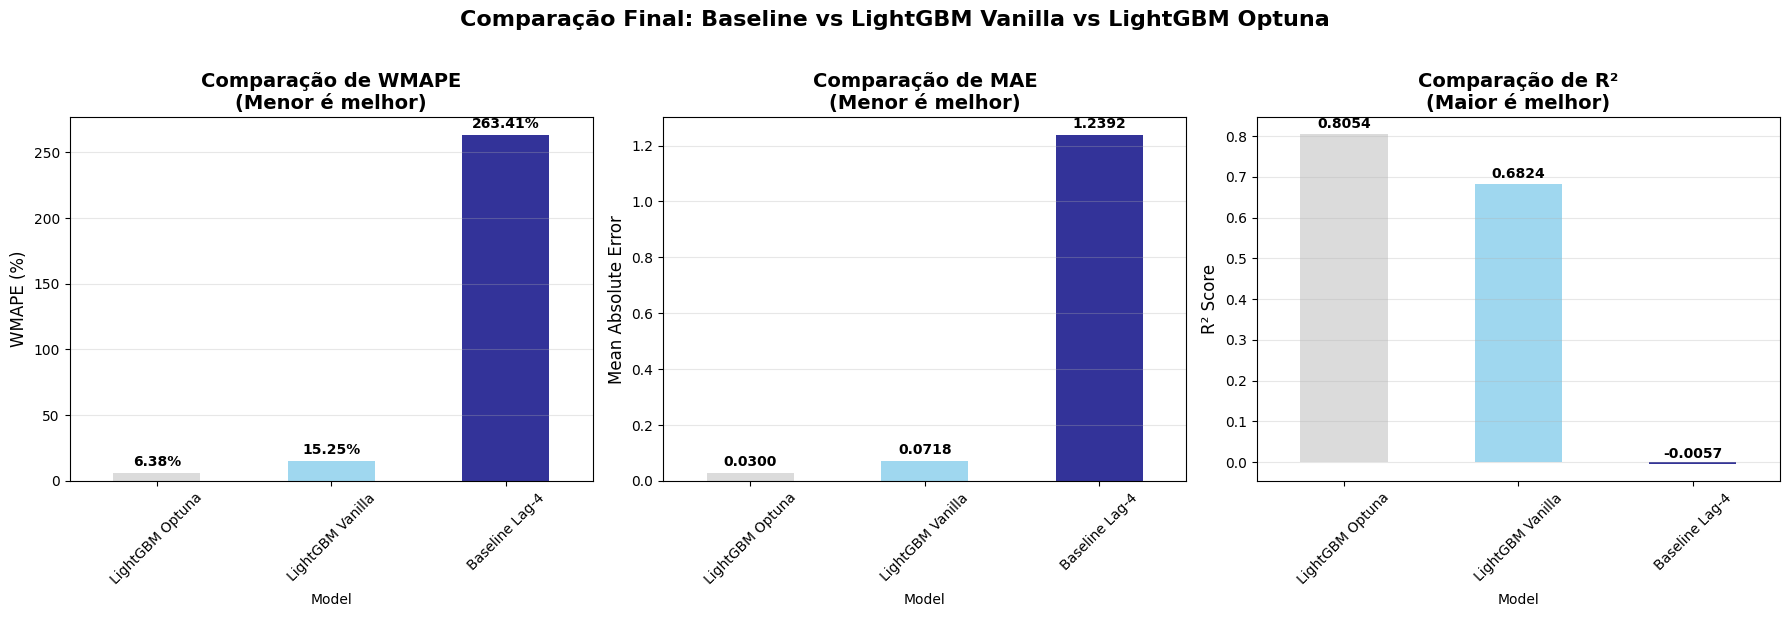


📈 Visualização da melhoria Optuna vs Vanilla...


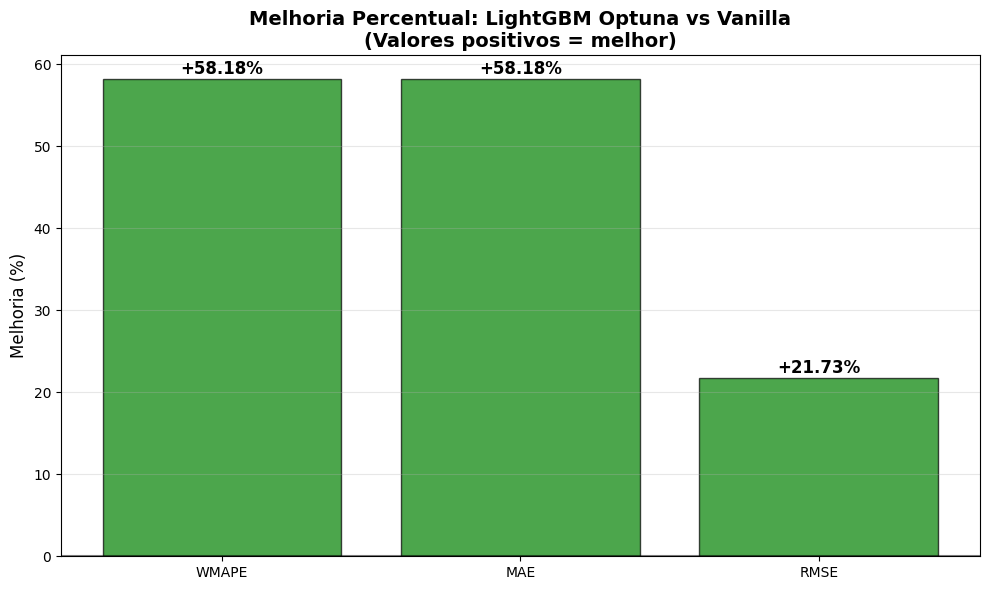


📋 RESUMO EXECUTIVO:
🎯 Objetivo: Comparar LightGBM Vanilla vs Optuna
📊 Métrica principal: WMAPE (Weighted Mean Absolute Percentage Error)

📈 Resultados:
   • Vanilla WMAPE: 15.25%
   • Optuna WMAPE:  6.38%
   • Melhoria:      +58.18%

✅ RECOMENDAÇÃO: Usar parâmetros Optuna na submissão final!

🎉 Análise completa finalizada!


In [9]:
# VISUALIZAÇÕES E ANÁLISE FINAL
print('📊 Criando visualizações da comparação...')

# Verificar se temos dados suficientes
if len(comparison_df) >= 2:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. Comparação de WMAPE
    wmape_data = comparison_df.set_index('Model')['WMAPE']
    colors = ['lightgray', 'skyblue', 'navy'][:len(wmape_data)]
    wmape_data.plot(kind='bar', ax=axes[0], color=colors, alpha=0.8)
    axes[0].set_title('Comparação de WMAPE\n(Menor é melhor)', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('WMAPE (%)', fontsize=12)
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(axis='y', alpha=0.3)
    
    # Adicionar valores nas barras
    for i, v in enumerate(wmape_data.values):
        axes[0].text(i, v + max(wmape_data.values) * 0.01, f'{v:.2f}%', 
                    ha='center', va='bottom', fontweight='bold')
    
    # 2. Comparação de MAE
    mae_data = comparison_df.set_index('Model')['MAE']
    mae_data.plot(kind='bar', ax=axes[1], color=colors, alpha=0.8)
    axes[1].set_title('Comparação de MAE\n(Menor é melhor)', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Mean Absolute Error', fontsize=12)
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(axis='y', alpha=0.3)
    
    # Adicionar valores nas barras
    for i, v in enumerate(mae_data.values):
        axes[1].text(i, v + max(mae_data.values) * 0.01, f'{v:.4f}', 
                    ha='center', va='bottom', fontweight='bold')
    
    # 3. Comparação de R²
    r2_data = comparison_df.set_index('Model')['R²']
    r2_data.plot(kind='bar', ax=axes[2], color=colors, alpha=0.8)
    axes[2].set_title('Comparação de R²\n(Maior é melhor)', fontsize=14, fontweight='bold')
    axes[2].set_ylabel('R² Score', fontsize=12)
    axes[2].tick_params(axis='x', rotation=45)
    axes[2].grid(axis='y', alpha=0.3)
    
    # Adicionar valores nas barras
    for i, v in enumerate(r2_data.values):
        axes[2].text(i, v + max(r2_data.values) * 0.01, f'{v:.4f}', 
                    ha='center', va='bottom', fontweight='bold')
    
    plt.suptitle('Comparação Final: Baseline vs LightGBM Vanilla vs LightGBM Optuna', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

    # Gráfico de melhoria percentual (se temos Vanilla e Optuna)
    if 'LightGBM Optuna' in available_models and 'LightGBM Vanilla' in available_models:
        print('\n📈 Visualização da melhoria Optuna vs Vanilla...')
        
        vanilla_results = comparison_df[comparison_df['Model'] == 'LightGBM Vanilla'].iloc[0]
        optuna_results = comparison_df[comparison_df['Model'] == 'LightGBM Optuna'].iloc[0]
        
        # Calcular melhorias percentuais
        improvements = {
            'WMAPE': ((vanilla_results['WMAPE'] - optuna_results['WMAPE']) / vanilla_results['WMAPE']) * 100,
            'MAE': ((vanilla_results['MAE'] - optuna_results['MAE']) / vanilla_results['MAE']) * 100,
            'RMSE': ((vanilla_results['RMSE'] - optuna_results['RMSE']) / vanilla_results['RMSE']) * 100
        }
        
        fig, ax = plt.subplots(figsize=(10, 6))
        metrics = list(improvements.keys())
        values = list(improvements.values())
        colors_improvement = ['green' if v > 0 else 'red' for v in values]
        
        bars = ax.bar(metrics, values, color=colors_improvement, alpha=0.7, edgecolor='black')
        ax.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        ax.set_title('Melhoria Percentual: LightGBM Optuna vs Vanilla\n(Valores positivos = melhor)', 
                     fontsize=14, fontweight='bold')
        ax.set_ylabel('Melhoria (%)', fontsize=12)
        ax.grid(axis='y', alpha=0.3)
        
        # Adicionar valores nas barras
        for bar, value in zip(bars, values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.1 if height > 0 else height - 0.3,
                   f'{value:+.2f}%', ha='center', va='bottom' if height > 0 else 'top', 
                   fontweight='bold', fontsize=12)
        
        plt.tight_layout()
        plt.show()
        
        # Resumo final
        print(f'\n📋 RESUMO EXECUTIVO:')
        print('=' * 50)
        print(f'🎯 Objetivo: Comparar LightGBM Vanilla vs Optuna')
        print(f'📊 Métrica principal: WMAPE (Weighted Mean Absolute Percentage Error)')
        print(f'\n📈 Resultados:')
        print(f'   • Vanilla WMAPE: {vanilla_results["WMAPE"]:.2f}%')
        print(f'   • Optuna WMAPE:  {optuna_results["WMAPE"]:.2f}%')
        print(f'   • Melhoria:      {improvements["WMAPE"]:+.2f}%')
        
        if improvements["WMAPE"] > 1:
            print(f'\n✅ RECOMENDAÇÃO: Usar parâmetros Optuna na submissão final!')
        elif improvements["WMAPE"] > 0:
            print(f'\n🤔 RECOMENDAÇÃO: Leve vantagem para Optuna. Considere usar na submissão.')
        else:
            print(f'\n❌ RECOMENDAÇÃO: Manter parâmetros Vanilla.')
            
else:
    print('⚠️ Dados insuficientes para visualizações completas')
    if len(comparison_df) > 0:
        print('Dados disponíveis:')
        print(comparison_df)

print(f'\n🎉 Análise completa finalizada!')